<a href="https://colab.research.google.com/github/andrewbowen19/CUNY-SQLBridge/blob/main/notebooks/bowen_chap20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Empire State Building Strikes Back

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
!pip install --q pint
!pip install --q modsimpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.0/294.0 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
# install Pint if necessary

try:
    from pint import UnitRegistry
except ImportError:
    !pip install pint

# import units
from pint import UnitRegistry
units = UnitRegistry()

In [3]:
# download modsim.py if necessary

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://raw.githubusercontent.com/AllenDowney/' +
         'ModSimPy/master/modsim.py')

Downloaded modsim.py


In [4]:
# import functions from modsim

from modsim import *

This chapter is available as a Jupyter notebook where you can read the text, run the code, and work on the exercises.
Click here to access the notebooks: <https://allendowney.github.io/ModSimPy/>.

So far the differential equations we've worked with have been *first order*, which means they involve only first derivatives. In this
chapter, we turn our attention to *second order* differential equations, which can involve both first and second derivatives.

We'll revisit the falling penny example from Chapter 1, and use `run_solve_ivp` to find the position and velocity of the penny as it falls, with and without air resistance.

## Newton's Second Law of Motion

First order differential equations (DEs) can be written

$$\frac{dy}{dx} = G(x, y)$$

where $G$ is some function of $x$ and $y$ (see <http://modsimpy.com/ode>). Second order DEs can be written

$$\frac{d^2y}{dx^2} = H(x, y, \frac{dy}{dt})$$

where $H$ is a function of $x$, $y$, and $dy/dx$.

In this chapter, we will work with one of the most famous and useful
second order DEs, Newton's second law of motion:

$$F = m a$$

where $F$ is a force or the total of a set of forces, $m$ is the mass of a moving object, and $a$ is its acceleration.

Newton's law might not look like a differential equation, until we
realize that acceleration, $a$, is the second derivative of position,
$y$, with respect to time, $t$. With the substitution

$$a = \frac{d^2y}{dt^2}$$

Newton's law can be written

$$\frac{d^2y}{dt^2} = F / m$$

And that's definitely a second order DE.
In general, $F$ can be a function of time, position, and velocity.

Of course, this "law" is really a model in the sense that it is a
simplification of the real world. Although it is often approximately
true:

-   It only applies if $m$ is constant. If mass depends on time,
    position, or velocity, we have to use a more general form of
    Newton's law (see <http://modsimpy.com/varmass>).

-   It is not a good model for very small things, which are better
    described by another model, quantum mechanics.

-   And it is not a good model for things moving very fast, which are
    better described by yet another model, relativistic mechanics.

However, for medium-sized things with constant mass, moving at
medium-sized speeds, Newton's model is extremely useful. If we can
quantify the forces that act on such an object, we can predict how it
will move.

## Dropping Pennies

As a first example, let's get back to the penny falling from the Empire State Building, which we considered in Chapter 1. We will implement two models of this system: first without air resistance, then with.

Given that the Empire State Building is 381 m high, and assuming that
the penny is dropped from a standstill, the initial conditions are:

In [5]:
init = State(y=381, v=0)

where `y` is height above the sidewalk and `v` is velocity.

I'll put the initial conditions in a `System` object, along with the magnitude of acceleration due to gravity, `g`, and the duration of the simulations, `t_end`.

In [6]:
system = System(init=init,
                g=9.8,
                t_end=10)

Now we need a slope function, and here's where things get tricky. As we have seen, `run_solve_ivp` can solve systems of first order DEs, but Newton's law is a second order DE. However, if we recognize that

1.  Velocity, $v$, is the derivative of position, $dy/dt$, and

2.  Acceleration, $a$, is the derivative of velocity, $dv/dt$,

we can rewrite Newton's law as a system of first order ODEs:

$$\frac{dy}{dt} = v$$

$$\frac{dv}{dt} = a$$

And we can translate those
equations into a slope function:

In [7]:
def slope_func(t, state, system):
    y, v = state

    dydt = v
    dvdt = -system.g

    return dydt, dvdt

As usual, the parameters are a time stamp, a `State` object, and a `System` object.

The first line unpacks the state variables, `y` and `v`.

The next two lines compute the derivatives of the state variables, `dydt` and `dvdt`.
The derivative of position is velocity, and the derivative of velocity is acceleration.
In this case, $a = -g$, which indicates that acceleration due to gravity is in the direction of decreasing $y$.

`slope_func` returns a sequence containing the two derivatives.

Before calling `run_solve_ivp`, it is a good idea to test the slope
function with the initial conditions:

In [8]:
dydt, dvdt = slope_func(0, system.init, system)
dydt, dvdt

(0, -9.8)

The result is 0 m/s for velocity and -9.8 m/s$^2$ for acceleration.

Now we call `run_solve_ivp` like this:

In [9]:
results, details = run_solve_ivp(system, slope_func)
details.message

'The solver successfully reached the end of the integration interval.'

`results` is a `TimeFrame` with two columns: `y` contains the height of the penny; `v` contains its velocity.
Here are the first few rows.

In [10]:
results.head()

,y,v
0.0,381.000,0.00
0.1,380.951,-0.98
0.2,380.804,-1.96
0.3,380.559,-2.94
0.4,380.216,-3.92


We can plot the results like this:

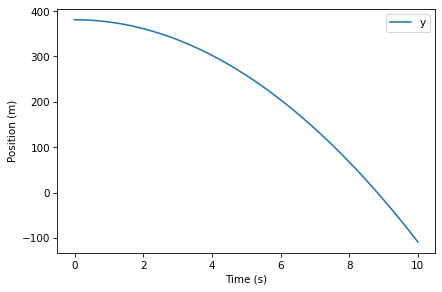

In [11]:
results.y.plot()

decorate(xlabel='Time (s)',
         ylabel='Position (m)')

Since acceleration is constant, velocity increases linearly and position decreases quadratically; as a result, the height curve is a parabola.

The last value of `results.y` is negative, which means we ran the simulation too long.

In [12]:
results.iloc[-1].y

-108.99999999999983

One way to solve this problem is to use the results to
estimate the time when the penny hits the sidewalk.

The ModSim library provides `crossings`, which takes a `TimeSeries` and a value, and returns a sequence of times when the series passes through the value. We can find the time when the height of the penny is `0` like this:

In [13]:
t_crossings = crossings(results.y, 0)
t_crossings

array([8.81788535])

The result is an array with a single value, 8.818 s. Now, we could run
the simulation again with `t_end = 8.818`, but there's a better way.

## Events

As an option, `run_solve_ivp` can take an *event function*, which
detects an "event", like the penny hitting the sidewalk, and ends the
simulation.

Event functions take the same parameters as slope functions, `t`, `state`, and `system`. They should return a value that passes through `0` when the event occurs. Here's an event function that detects the penny hitting the sidewalk:

In [14]:
def event_func(t, state, system):
    y, v = state
    return y

The return value is the height of the penny, `y`, which passes through
`0` when the penny hits the sidewalk.

We pass the event function to `run_solve_ivp` like this:

In [15]:
results, details = run_solve_ivp(system, slope_func,
                                 events=event_func)
details.message

'A termination event occurred.'

Then we can get the flight time like this:

In [16]:
t_end = results.index[-1]
t_end

8.817885349720553

And the final velocity like this:

In [17]:
y, v = results.iloc[-1]
y, v

(0.0, -86.41527642726145)

If there were no air resistance, the penny would hit the sidewalk (or someone's head) at about 86 m/s. So it's a good thing there is air resistance.

## Summary

In this chapter, we wrote Newton's second law, which is a second order DE, as a system of first order DEs.
Then we used `run_solve_ivp` to simulate a penny dropping from the Empire State Building in the absence of air resistance.
And we used an event function to stop the simulation when the penny reaches the sidewalk.

In the next chapter we'll add air resistance to the model.
But first you might want to work on this exercise.

### Exercise 1

Here's a question from the web site *Ask an Astronomer* (see http://curious.astro.cornell.edu/about-us/39-our-solar-system/the-earth/other-catastrophes/57-how-long-would-it-take-the-earth-to-fall-into-the-sun-intermediate):

> "If the Earth suddenly stopped orbiting the Sun, I know eventually it would be pulled in by the Sun's gravity and hit it. How long would it take the Earth to hit the Sun? I imagine it would go slowly at first and then pick up speed."

Use `run_solve_ivp` to answer this question.

Here are some suggestions about how to proceed:

1.  Look up the Law of Universal Gravitation and any constants you need.  I suggest you work entirely in SI units: meters, kilograms, and Newtons.

2.  When the distance between the Earth and the Sun gets small, this system behaves badly, so you should use an event function to stop when the surface of Earth reaches the surface of the Sun.

3. Express your answer in days, and plot the results as millions of kilometers versus days.

If you read the reply by Dave Rothstein, you will see other ways to solve the problem, and a good discussion of the modeling decisions behind them.

You might also be interested to know that it's not that easy to get to the Sun; see https://www.theatlantic.com/science/archive/2018/08/parker-solar-probe-launch-nasa/567197/.

In [46]:
# Initialize system
# https://www.google.com/search?client=safari&rls=en&q=how+many+meters+to+sun&ie=UTF-8&oe=UTF-8
init = State(distance=149597870700, v_0=0)


# Treat sun and earth as point masses
t_end = 1e7  # seconds
G = 6.674e-11

radius_sun = 10e7
radius_earth = 6371000
system = System(init=init,
                G=G,   # N m^2 / kg^2
                m1=1.989e30,   # kg
                m2=5.972e24,   # kg
                r_final=radius_sun + radius_earth,
                t_end=t_end)

In [47]:
# Solution goes here
def gravitational_force(m1, m2, r):
  """Calculate the gravitational force between masses m1 and m2 at radius r"""
  return G * m1 * m2 / (r**2)

In [50]:
# Solution goes here
def slope_func2(t, state, system):
  m2 = system.m2
  f_g = gravitational_force(system.m1, m2, system.r_final)
  dvdt = -f_g / m2 # rewritten form of Newton's 2ns law
  dydt = state[1]

  return dydt, dvdt


In [45]:
# Solution goes here
help(run_solve_ivp)

Help on function run_solve_ivp in module modsim:

run_solve_ivp(system, slope_func, **options)
    Computes a numerical solution to a differential equation.
    
    `system` must contain `init` with initial conditions,
    `t_end` with the end time.  Optionally, it can contain
    `t_0` with the start time.
    
    It should contain any other parameters required by the
    slope function.
    
    `options` can be any legal options of `scipy.integrate.solve_ivp`
    
    system: System object
    slope_func: function that computes slopes
    
    returns: TimeFrame



In [57]:
# We also will need to define an event function
def event_func2(t, state, system):
    r, v = state
    return r - system.r_final

In [60]:
# Get solution using run_solv_ivp
results2, message = run_solve_ivp(system, slope_func2, event_func=event_func2)
results2

/usr/local/lib/python3.10/dist-packages/scipy/integrate/_ivp/common.py:39: UserWarning: The following arguments have no effect for a chosen solver: `event_func`.
  warn("The following arguments have no effect for a chosen solver: {}."


,distance,v_0
0.0,1.495979e+11,0.000000e+00
100000.0,-5.851073e+13,-1.173207e+09
200000.0,-2.344917e+14,-2.346413e+09
300000.0,-5.277934e+14,-3.519620e+09
400000.0,-9.384157e+14,-4.692826e+09
...,...,...
9600000.0,-5.406135e+17,-1.126278e+11
9700000.0,-5.519349e+17,-1.138010e+11
9800000.0,-5.633737e+17,-1.149742e+11
9900000.0,-5.749297e+17,-1.161475e+11


In [67]:
# Need to convert time into days and distance into
results2.index = results2.index / (60 * 60  * 24)


results2.distance /= 1e9

In [68]:
# Solution goes here
import matplotlib.pyplot as plt

Text(0, 0.5, 'Distance change (millions km)')

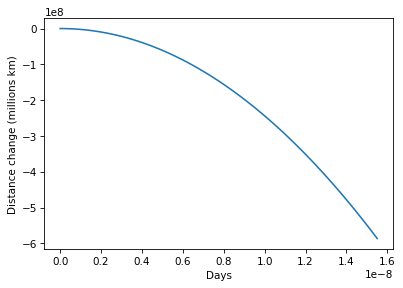

In [71]:
# Plotting our results
plt.plot(results2.index, results2.distance)
plt.xlabel("Days")
plt.ylabel("Distance change (millions km)")